## Introduction

Welcome to the DSN Internship Coding Challenge! This assessment will put your Natural Language Processing (NLP) and problem-solving abilities to the test. :

- Section one of the assessmnet will require you to build a text classification model.

Good luck! If you have questions about the framing of the questions, please contact **recruitment@datasciencenigeria.ai**

### How to Use and Submit this Notebook.
- Make a copy of this document and rename it **Firstname_Lastname_DSNInternshipCodingAssessment.ipynb**
- Before attempting to submit, ensure that you have ran all of the cells in your notebook and the output visible.
- Once you’ve completed all tasks, save and download a copy of the notebook as .ipynb
- Submit a link (make sure that the link is set to "Anyone on the internet with the link can view"), the downloaded copy of your final notebook via this [link](https://forms.gle/t8sFNrfAymZUrfJq7).

### What Not to Do.
- Do not share this document with any external party
- No teamwork is permitted
- After submitting a copy of your script, you are not permitted to make any changes to the online version; any discrepancy between the online and submitted copies will render your application null and void.

### Dataset

This is a news [dataset](https://drive.google.com/file/d/1NgPM7_mFCDKnuqI9SamMCrkF1mE5AgAI/view?usp=sharing) which contains 2225 examples of news articles with their respective labels. Use to the link to learn more about the dataset

## Section 1

### Task

**This is to test your knowledge on NLP**

Build and train a machine learning model with the provided dataset to classify the news category or topic. You can use any architecture or model, in this test.

**Make sure to plot the accuracy vs epochs and loss vs epochs graphs**

In [ ]:
#Building the news category classification model
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.en import STOP_WORDS
from bs4 import BeautifulSoup
import string
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.metrics import hinge_loss
from sklearn.svm import LinearSVC

In [ ]:
news_df = pd.read_csv("/bbc-text.csv")
print(news_df.shape)
news_df.head()

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


## Data Exploration

In [ ]:
#There are five distinct news categories. This is a multiclass classification model
news_df["category"].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [ ]:
#The data has no missing values
news_df.isnull().sum()

category    0
text        0
dtype: int64

Text(0, 0.5, 'Counts in percentage')

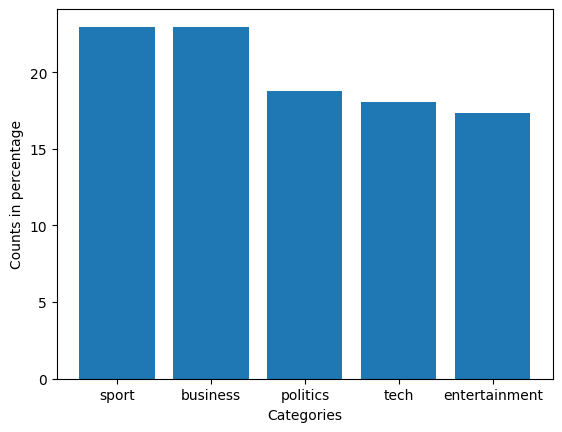

In [ ]:
#Checking for class imbalance. The data seems relatively balanced. Still try out class balancing techniques
category_count = news_df["category"].value_counts()
percentage_count = (category_count.values/category_count.values.sum()) * 100
plt.bar(category_count.index, percentage_count)
plt.xlabel("Categories")
plt.ylabel("Counts in percentage")

In [ ]:
#Setting my random state for reproducibility.
np.random.seed(42)

In [ ]:
## Data Preprocessing

In [ ]:
#Splitting my data into train, test, and validation
X = news_df["text"]
y = news_df["category"]
#Encoding the y variables
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [ ]:
#Checking the y_label encoding
mappings = {v:i for i, v in enumerate(list(encoder.classes_))}
print(mappings)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [ ]:
#Visualising my split dataset
print("The number of data points in train data", len(x_train))
print("The number of data points in test data", len(x_test))
print("The number of data points in validation data", len(x_val))

The number of data points in train data 1424
The number of data points in test data 445
The number of data points in validation data 356


In [ ]:
def html_parsing(corpus):
    corpus = [text.replace("\"", "") for text in corpus]
    corpus = [BeautifulSoup(text).get_text().lower().replace("\'", "") for text in corpus]
    return corpus

In [ ]:
#From inspection of the dataset there are no html tags. Since most text data are usually scraped off the web I would just
#pass the text through a html parser just to be sure.
x_train = html_parsing(x_train)
x_test = html_parsing(x_test)
x_val = html_parsing(x_val)

In [ ]:
#Inco-operating negation handling to improve the generalization ability of the model.
import nltk

# Define a comprehensive list of negation words
negation_words = ["no", "not", "never", "none", "nobody", "nothing", "neither", "nowhere",
                  "hardly", "scarcely", "barely", "aint"]

# Define a function to handle negations
def handle_negations(corpus):
    data = []
    for text in corpus:
        # Tokenize the text
        tokens = word_tokenize(text)
        # Initialize the list of words to be used for sentiment analysis
        sentiment_words = []
        i = 0
        # Iterate through the tokens
        while i < len(tokens):
            # Check if the current token is a negation word
            if tokens[i].lower() in negation_words:
                # If it is, append "not_" to the next token
                if i+1 < len(tokens):
                    sentiment_words.append("not_"+tokens[i+1])
                    i +=1
            else:
                # If it is not, append the token to the list of sentiment words
                sentiment_words.append(tokens[i])
            i += 1
        # Join the sentiment words back into a string
        processed_text = " ".join(sentiment_words)
        data.append(processed_text)
    return data

In [ ]:
x_train = handle_negations(x_train)
x_test = handle_negations(x_test)
x_val = handle_negations(x_val)

In [ ]:
#Does other necessary cleaning operations including removal of punctuations, digits and stop words. Also performed
#Lemmatization in this step
nlp = spacy.load("en_core_web_sm")
def clean(data):
    data_ = []
    #Removing all punctuation
    x = [text.translate(str.maketrans('', '', string.punctuation)) for text in data]
    #Removing all digits
    x = [text.translate(str.maketrans('', '', string.digits)) for text in x]
    #Removing stopwords and lemmatization
    for i in x:
        doc = nlp(i)
        data_.append(' '.join([text.lemma_ for text in doc if text.text not in STOP_WORDS]))
    return data_

In [ ]:
#Cleaning the dataset
x_train = clean(x_train)
x_test = clean(x_test)
x_val = clean(x_val)

In [ ]:
#Converting the dataset to a bag of words model
vect = TfidfVectorizer()
#fitting the countvectorizer with the training dataset
x_train_dtm = vect.fit_transform(x_train)
#Trasforming the test and validation dataset
x_test_dtm = vect.transform(x_test)
x_val_dtm= vect.transform(x_val)

In [ ]:
#The model has 20734 features. This too much I guess and might introduce noise or cause overfitting
print(x_val_dtm.shape)
print(x_train_dtm.shape)
print(x_test_dtm.shape)

(356, 20734)
(1424, 20734)
(445, 20734)


In [ ]:
#I tried making a perfect balnce of the classes but it didnt improve the training and test scores
# #Handling class imbalance
# over = SMOTE()
# x_train_dtm, y_train = over.fit_resample(x_train_dtm, y_train)
# under = RandomUnderSampler()
# x_train_dtm, y_train = under.fit_resample(x_train_dtm, y_train)

## Modelling

## Naive Bayes MultinomialNB Model

In [ ]:
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes classifier
nb.fit(x_train_dtm, y_train)#train the model

MultinomialNB()

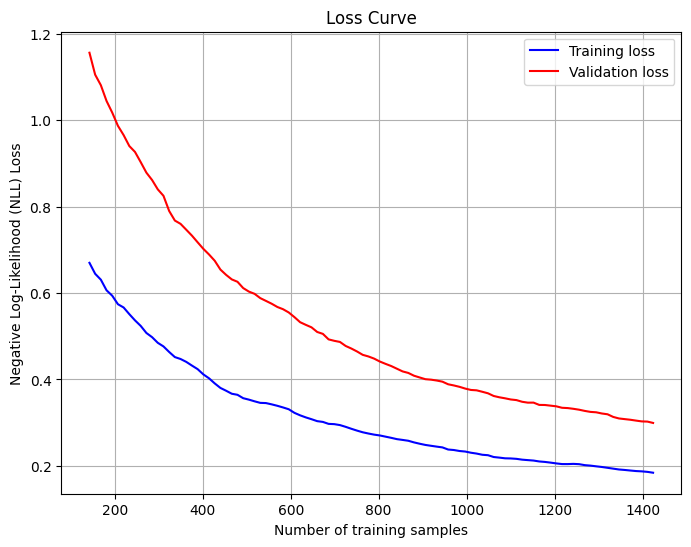

In [ ]:
#Creating the loss curve
#I used log-loss to generate the loss scores for n-subset of training examples
# Defining the number of training samples as fractions
train_sizes = np.linspace(0.1, 1.0, 100)

# Initializing empty lists to store loss values
train_losses = []
test_losses = []

# Computing loss curve values
for train_size in train_sizes:
    train_subset_size = int(train_size * x_train_dtm.shape[0])
    x_train_subset = x_train_dtm[:train_subset_size]
    y_train_subset = y_train[:train_subset_size]

    nb.fit(x_train_subset, y_train_subset)

    train_pred_prob = nb.predict_proba(x_train_subset)
    train_loss = log_loss(y_train_subset, train_pred_prob)
    train_losses.append(train_loss)

    test_pred_prob = nb.predict_proba(x_test_dtm)
    test_loss = log_loss(y_test, test_pred_prob)
    test_losses.append(test_loss)

# Plotting loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * x_train_dtm.shape[0], train_losses, label='Training loss', color='blue')
plt.plot(train_sizes * x_train_dtm.shape[0], test_losses, label='Validation loss', color='red')
plt.xlabel('Number of training samples')
plt.ylabel('Negative Log-Likelihood (NLL) Loss')
plt.title('Loss Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


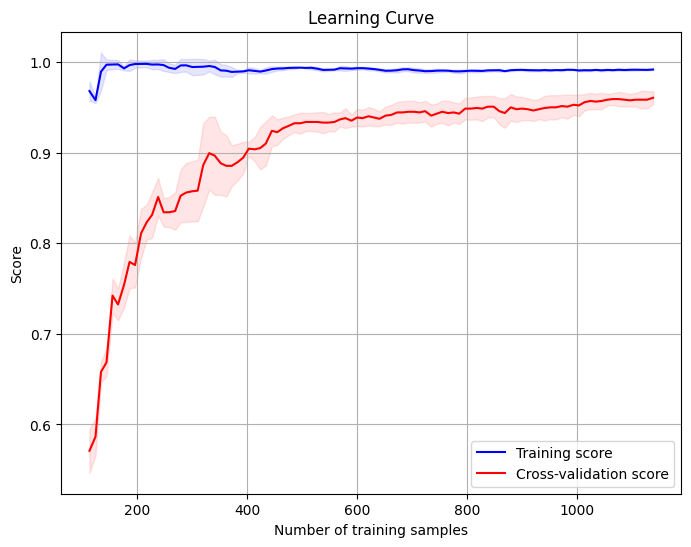

In [ ]:
#Plotting the learning curve
# Definining the number of training samples as fractions
train_sizes = np.linspace(0.1, 1.0, 100)

# Computing learning curve scores
train_sizes_abs, train_scores, test_scores = learning_curve(nb, x_train_dtm, y_train, train_sizes=train_sizes, cv=5)

# Computing mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes_abs, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes_abs, test_mean, label='Cross-validation score', color='red')
plt.fill_between(train_sizes_abs, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.xlabel('Number of training samples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
#Confusion matirx to evaluate performance of model(The diagonals indicate the performance of the model on each category)
def conf_mat(y, y_pred):
    conf_mat = confusion_matrix(y, y_pred, normalize="true")
    # Plot the confusion matrix
    sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=set(y_train), yticklabels=set(y_train))
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    print(accuracy_score(y, y_pred))

0.9901685393258427


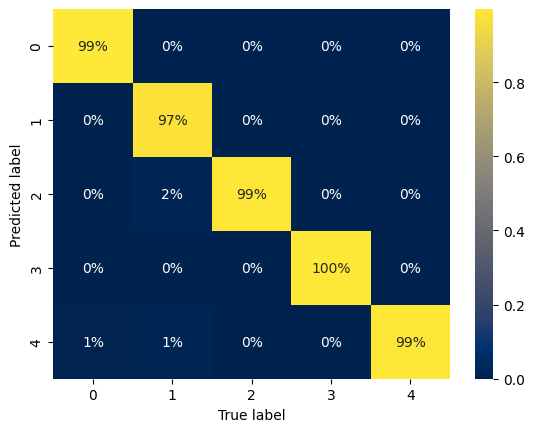

In [ ]:
y_pred = nb.predict(x_train_dtm)#make class predictions for test
conf_mat(y_train, y_pred)

0.9719101123595506


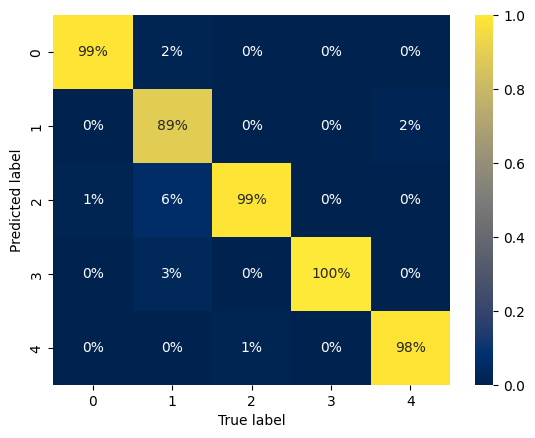

In [ ]:
y_pred = nb.predict(x_val_dtm)#make class predictions for test
conf_mat(y_val, y_pred)

0.9640449438202248


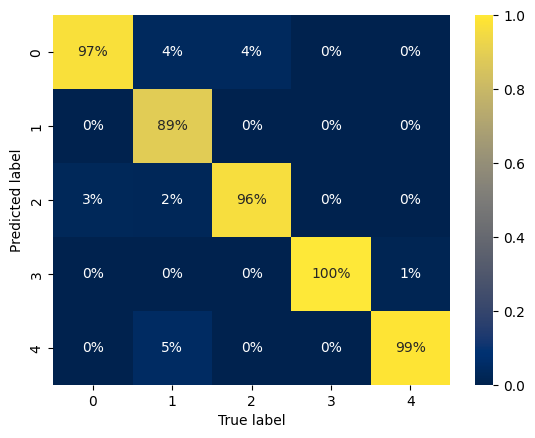

In [ ]:
y_pred_test = nb.predict(x_test_dtm)#make class predictions for test
conf_mat(y_test, y_pred_test)

## Linear SVM


In [ ]:
svm = LinearSVC(class_weight='balanced')
svm.fit(x_train_dtm, y_train)

LinearSVC(class_weight='balanced')

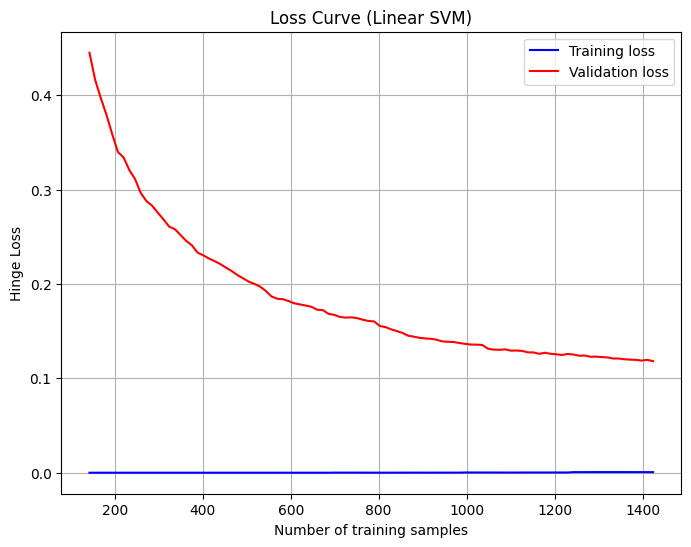

In [ ]:
#used the Hinge loss to evaluate the losses for n_training examples
# Defining the number of training samples as fractions
train_sizes = np.linspace(0.1, 1.0, 100)

# Initializing empty lists to store loss values
train_losses = []
test_losses = []

# Computing loss curve values
for train_size in train_sizes:
    train_subset_size = int(train_size * x_train_dtm.shape[0])
    x_train_subset = x_train_dtm[:train_subset_size]
    y_train_subset = y_train[:train_subset_size]

    svm = LinearSVC()
    svm.fit(x_train_subset, y_train_subset)

    train_pred = svm.decision_function(x_train_subset)
    train_loss = hinge_loss(y_train_subset, train_pred)
    train_losses.append(train_loss)

    test_pred = svm.decision_function(x_test_dtm)
    test_loss = hinge_loss(y_test, test_pred)
    test_losses.append(test_loss)

# Plotting loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * x_train_dtm.shape[0], train_losses, label='Training loss', color='blue')
plt.plot(train_sizes * x_train_dtm.shape[0], test_losses, label='Validation loss', color='red')
plt.xlabel('Number of training samples')
plt.ylabel('Hinge Loss')
plt.title('Loss Curve (Linear SVM)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


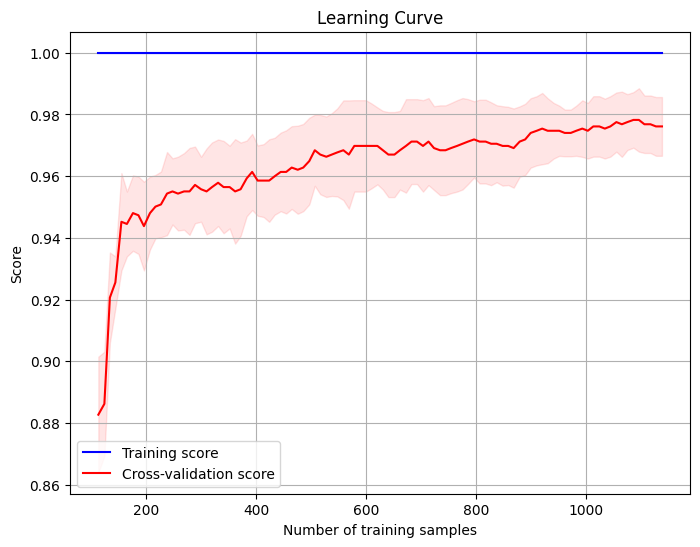

In [ ]:
#Creating the learning Curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Definining the number of training samples as fractions
train_sizes = np.linspace(0.1, 1.0, 100)

# Computing learning curve scores
train_sizes_abs, train_scores, test_scores = learning_curve(svm, x_train_dtm, y_train, train_sizes=train_sizes, cv=5)

# Computing mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes_abs, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes_abs, test_mean, label='Cross-validation score', color='red')
plt.fill_between(train_sizes_abs, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.xlabel('Number of training samples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


1.0


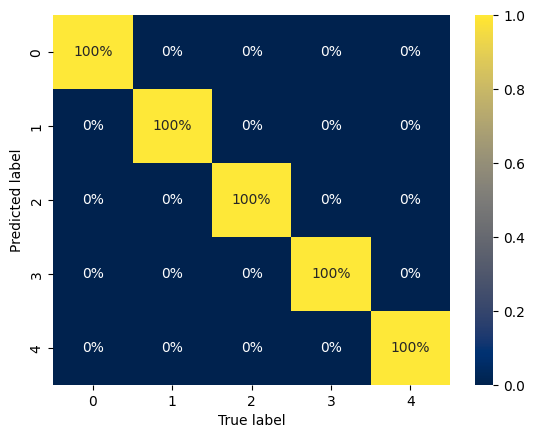

In [ ]:
#Evaluating model performance
y_pred = svm.predict(x_train_dtm)#make class predictions for test
conf_mat(y_train, y_pred)

0.9803370786516854


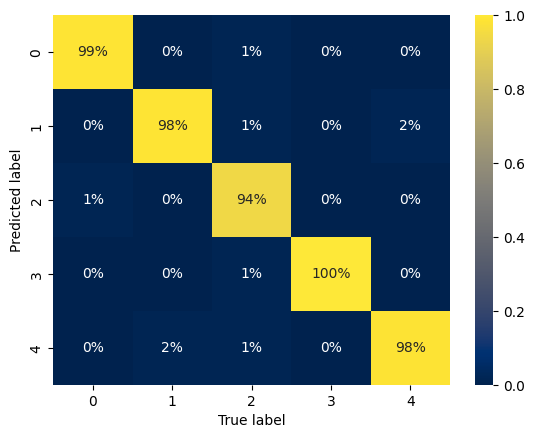

In [ ]:
y_pred = svm.predict(x_val_dtm)#make class predictions for test
conf_mat(y_val, y_pred)

0.9707865168539326


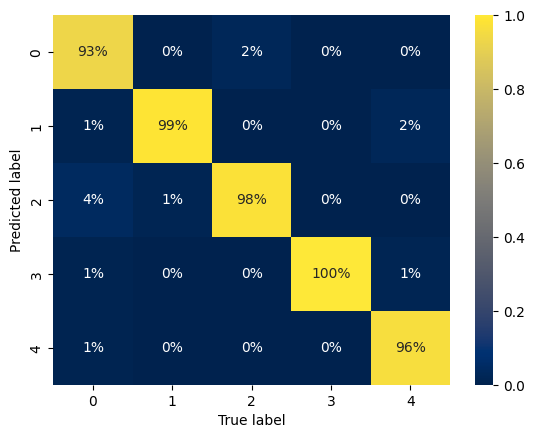

In [ ]:
y_pred_test = svm.predict(x_test_dtm)#make class predictions for test
conf_mat(y_test, y_pred_test)

##  Model Stacking
Stacking the Naive Bayes , Linear SVM model and Logistic Regression model together.where Naive Bayes and Linear SVM are the primary classification models and Logisistic Regression the secondary classification model

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
estimators = [("nb", nb), ("svm", svm)]
#Building stacked model
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
#Training stacked model
stack_model.fit(x_train_dtm, y_train)

StackingClassifier(estimators=[('nb', MultinomialNB()), ('svm', LinearSVC())],
                   final_estimator=LogisticRegression())

1.0


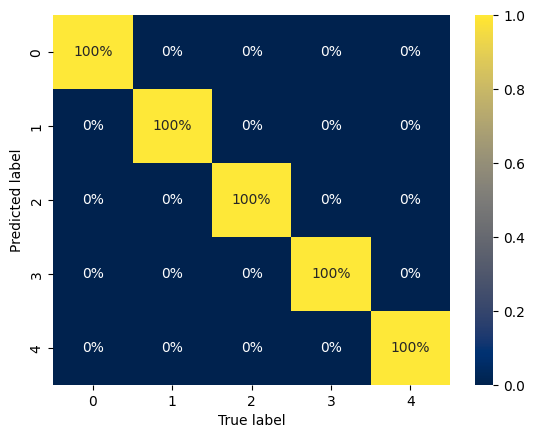

In [ ]:
#Evaluating model performance
y_pred_train = stack_model.predict(x_train_dtm)#make class predictions for test
conf_mat(y_train, y_pred_train)

0.9803370786516854


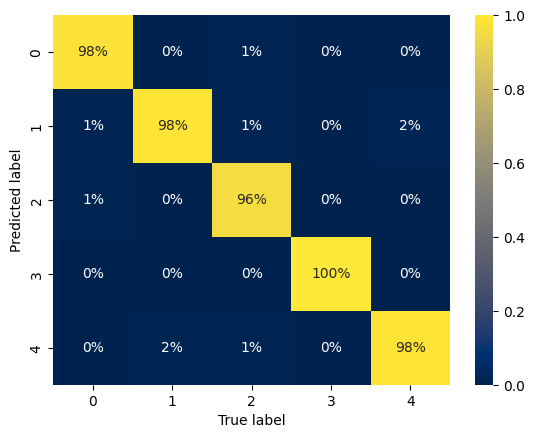

In [ ]:
#The validation set seems to have an improved accuracy of 98%
y_pred_val = stack_model.predict(x_val_dtm)#make class predictions for test
conf_mat(y_val, y_pred_val)

0.9707865168539326


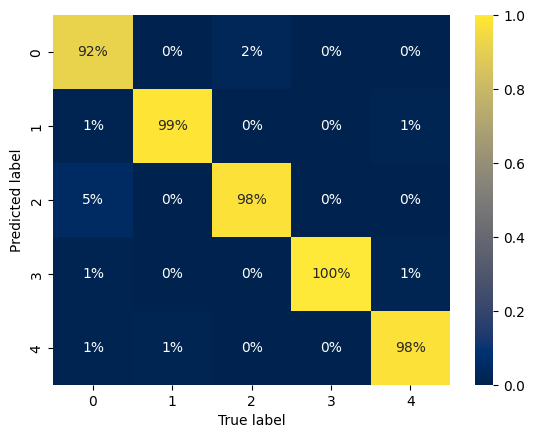

In [ ]:
y_pred_test = stack_model.predict(x_test_dtm)#make class predictions for test
conf_mat(y_test, y_pred_test)

## Building the recall metric from scratch in python


In [ ]:
#Building the recall metric
#y = Actual label
#y_pred = Predicted label
#tp = True positive(The number of correctly predicted classes)
#fn = False Negative(The number of incorrectly predicted classes)
#recall = recall score
def recall(y, y_pred):
    recall = 0
    tp = 0
    fn = 0
    if len(y) != len(y_pred):
        return "y and y_pred do not have equal dimensions"
    for i , j in zip(y, y_pred):
        if i == j:
            tp += 1
        else:
            fn += 1
    recall = tp / (tp +fn)
    return recall

In [ ]:
recall(np.zeros((10,1)), [0,0,0,1,0,1,1,1,0,0])

0.6